In [ ]:
import pandas as pd
import holidays
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv(r"C:\Time_Series_XGB\data\raw\historic_demand_2009_2024.csv", index_col=0)
df.columns = df.columns.str.lower()
df.drop(columns=["scottish_transfer", "viking_flow", "greenlink_flow"], inplace=True)


In [3]:
df.sample(n=7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
257492,2023-09-09,23,21882,23365,20010,555,6538,7152,15872,0,4,493,991,1003,-452,-527,999,1399.0,999.0,0
23641,2010-05-08,28,35348,36206,32155,920,2236,1,22,0,9,1102,0,0,-349,0,0,NaN,NaN,0
33326,2010-11-26,15,44757,47528,40749,778,2139,0,68,0,13,-2045,0,0,-113,0,0,NaN,NaN,0
220652,2021-08-02,39,30380,31608,27641,453,6527,704,13080,0,9,2004,992,1003,-453,-266,1019,-1.0,0.0,0
252688,2023-06-01,19,25997,27481,23541,1309,6538,2864,15531,0,5,1998,991,1005,-452,-527,999,1298.0,998.0,0
155868,2017-11-22,13,27183,30292,24630,2144,5305,0,12372,0,595,-1914,0,802,76,495,0,NaN,NaN,0
263478,2024-01-12,7,25819,31694,23231,857,6488,0,16752,0,1105,-883,-4,-592,-452,-531,-573,-7.0,-632.0,0


In [4]:
df.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
count,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,279264.000000,103968.000000,103968.000000,279264.000000
mean,24.500229,31186.565042,32627.843779,28389.002868,1270.098774,4447.695772,878.177069,8685.163430,6.654220,304.734674,926.205544,53.852140,503.999842,-125.610222,-50.967919,175.876626,416.582977,114.173929,0.022516
std,13.853821,7827.270027,7710.008440,7087.628201,966.304596,1957.216235,1709.142408,5875.188186,39.150778,528.372063,1067.861437,353.722565,541.490053,230.333166,262.941668,421.668169,650.866003,490.431568,0.148356
min,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,-2056.000000,-1030.000000,-1215.000000,-505.000000,-585.000000,-1023.000000,-1455.000000,-1028.000000,0.000000
25%,12.750000,24908.000000,26582.000000,22677.000000,551.000000,2102.000000,0.000000,2028.000000,0.000000,8.000000,273.000000,0.000000,0.000000,-304.000000,-208.000000,0.000000,0.000000,0.000000,0.000000
50%,24.500000,30495.000000,31782.000000,27756.000000,1016.000000,4831.000000,0.000000,11503.000000,0.000000,11.000000,1178.000000,0.000000,725.000000,-149.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.250000,36913.000000,38096.000000,33615.000000,1726.000000,6527.000000,883.000000,13080.000000,0.000000,368.000000,1891.000000,0.000000,994.000000,24.000000,0.000000,332.000000,1095.000000,75.000000,0.000000
max,50.000000,59095.000000,60147.000000,53325.000000,5930.000000,6622.000000,11224.000000,17197.000000,893.000000,2019.000000,2066.000000,1016.000000,1143.000000,499.000000,504.000000,1033.000000,1401.000000,1002.000000,1.000000


In [5]:
df.shape

(279264, 20)

In [6]:
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

In [7]:
df.isna().any()

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
is_holiday                   False
dtype: bool

In [8]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

,nsl_flow,eleclink_flow
True,175296,175296
False,103968,103968


In [9]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175291,2018-12-31,44,26826,28428,25195,2734,5918,0,13052,0,13,1960,0,777,-454,-535,0,NaN,NaN,0
175292,2018-12-31,45,25660,27542,24145,2730,5918,0,13052,0,23,1182,0,-268,-455,-536,0,NaN,NaN,0
175293,2018-12-31,46,25047,26971,23496,2726,5918,0,13052,0,36,1157,0,-297,-455,-536,0,NaN,NaN,0
175294,2018-12-31,47,24188,26224,22683,2673,5918,0,13052,0,49,1546,0,-467,-454,-466,0,NaN,NaN,0


In [10]:
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2025), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2025), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [12]:
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

[np.datetime64('2009-01-01'),
 np.datetime64('2009-04-10'),
 np.datetime64('2009-04-13'),
 np.datetime64('2009-05-04'),
 np.datetime64('2009-05-25')]

In [13]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
22053,2010-04-05,26,35718,36513,31768,1858,1883,0,18,0,5,1484,0,0,-290,0,0,1
210181,2020-12-28,14,25922,26911,23478,496,6527,0,13080,0,389,1892,-1,0,300,504,952,1
40876,2011-05-02,35,32439,33361,29169,1286,1786,43,155,0,8,849,0,-1,-413,0,0,1
34864,2010-12-28,21,41385,42440,37258,940,2141,1,78,0,4,458,0,0,-451,0,0,1
157423,2017-12-25,2,22522,23177,20809,3313,5754,0,12916,0,35,1008,0,544,-20,427,0,1
245143,2022-12-26,36,30558,31949,27966,2836,6545,0,13861,0,12,1005,992,1005,-451,-328,1019,1
52637,2012-01-02,36,45885,46366,41611,1133,1866,0,1128,128,9,1748,0,993,0,0,0,1


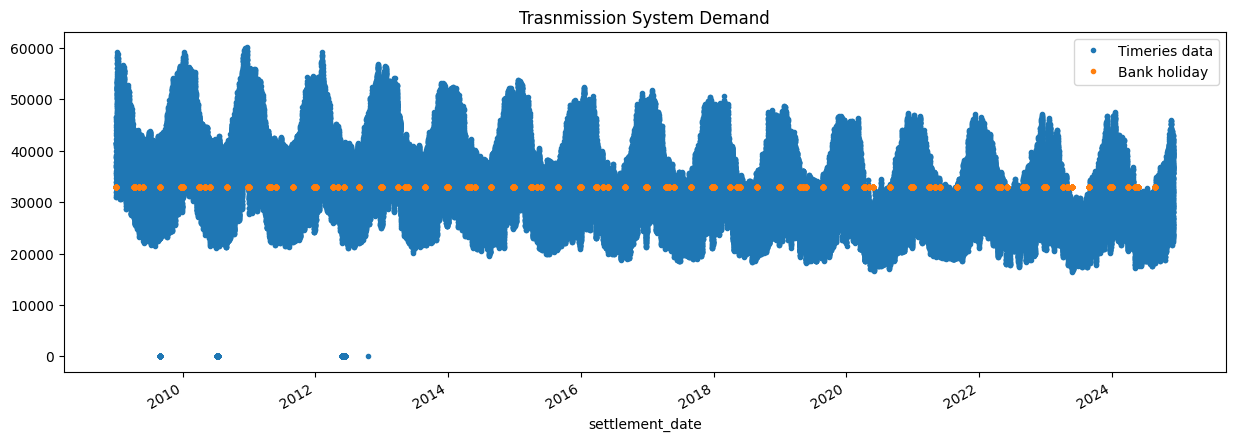

In [14]:
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend()

<Axes: xlabel='settlement_date'>

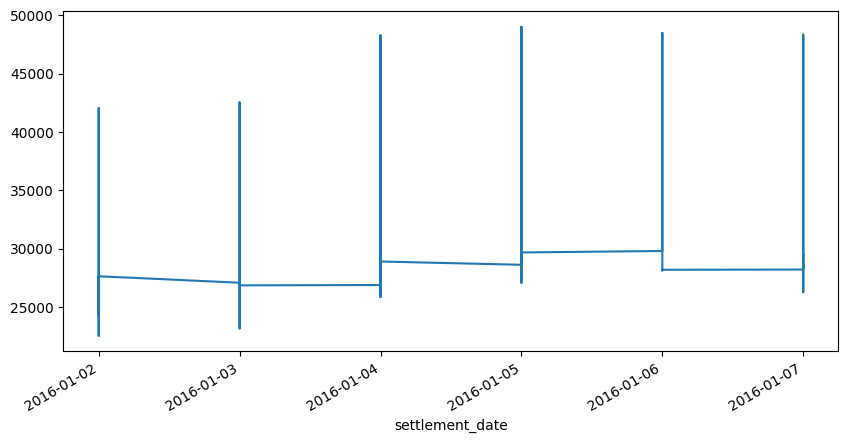

In [15]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5))

In [16]:
df_plot.head()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
settlement_date,,,,,,,,,,,,,,,,,
2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


In [17]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [18]:
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
58733,2012-05-14,38,18:30:00,39069,39992,35625,901,2019,287,1509,0,10,990,0,0,-413,0,0,0
101599,2014-11-02,44,21:30:00,31139,32387,28169,1066,3939,0,5569,0,11,1997,0,998,-246,-391,0,0
165668,2018-06-29,41,20:00:00,29803,30632,27195,1306,5913,554,13052,0,5,995,0,1000,-324,82,0,0
176637,2019-02-13,18,8:30:00,38701,39314,35871,2586,6192,650,13052,0,13,1998,0,1058,155,298,874,0
100884,2014-10-19,1,0:00:00,22858,23531,20986,2022,4127,0,5485,0,173,822,0,998,201,272,0,0
166092,2018-07-08,33,16:00:00,23925,24506,21839,931,5913,5790,13052,0,7,1997,0,1000,-67,-7,0,0
169052,2018-09-08,17,8:00:00,26449,26959,23959,1122,5911,688,13052,0,10,995,0,664,76,248,0,0


In [19]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
133116,2016-08-20 14:00:00,29,14:00:00,23549,24237,20982,2626,4353,4020,11100,0,9,-179,0,661,0,74,0,0
205162,2020-09-29 17:00:00,35,17:00:00,34225,34738,30991,489,6527,1290,13080,0,13,1962,0,206,246,214,711,0
202669,2020-08-08 18:30:00,38,18:30:00,26012,26803,23714,1082,6527,1600,13080,0,11,1904,0,899,-280,0,950,0
202595,2020-08-07 05:30:00,12,5:30:00,20354,22254,18671,897,6527,19,13080,0,10,-1390,0,0,245,504,172,0
104348,2014-12-30 04:00:00,9,4:00:00,27142,29438,24646,920,4039,0,5989,0,1548,1497,0,1039,-72,-76,0,0


<Axes: xlabel='settlement_date', ylabel='Electricity demand (MW)'>

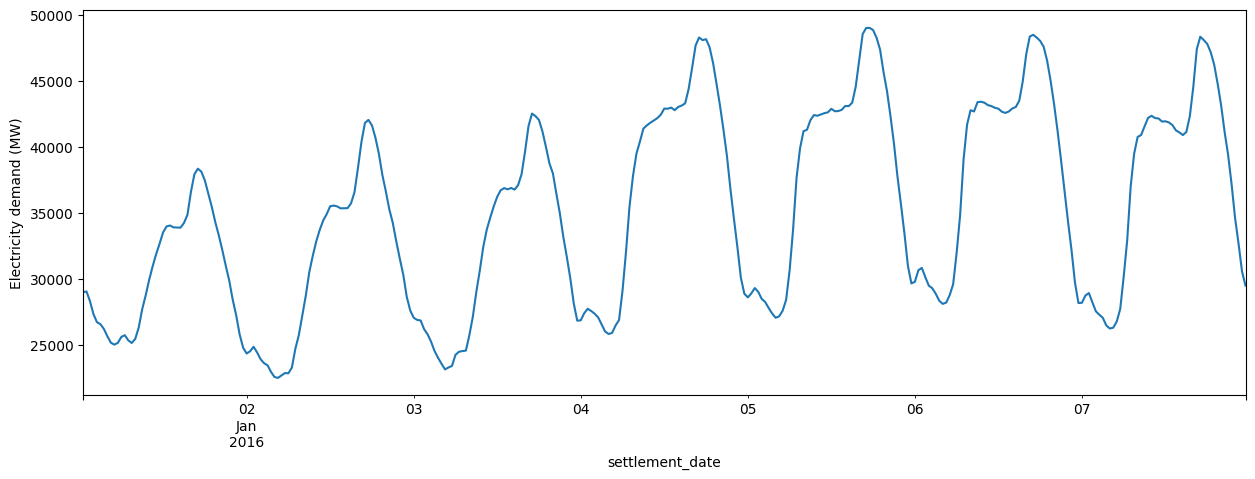

In [20]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
)

In [21]:
def create_features(df):
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df


def add_lags(df):
    target_map = df["tsd"].to_dict()
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [22]:
df = create_features(df)
df = add_lags(df)

df.sample(n=5)

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3
settlement_date,,,,,,,,,,,,,,,,,,,,,
2019-02-14 17:30:00,36,17:30:00,42732,43245,38846,1528,6192,0,13080,97,...,14,3,45,1,2,2019,7,45440.0,45923.0,47769.0
2009-02-04 19:00:00,39,19:00:00,53796,54534,48514,421,1405,0,0,0,...,4,2,35,1,2,2009,6,NaN,NaN,NaN
2012-11-22 14:30:00,30,14:30:00,43584,44447,39242,1436,2085,68,1994,0,...,22,3,327,4,11,2012,47,45421.0,51458.0,46712.0
2024-06-11 07:00:00,15,7:00:00,25110,26563,22874,1552,6562,2211,17193,0,...,11,1,163,2,6,2024,24,25598.0,27917.0,26721.0
2019-09-13 21:30:00,44,21:30:00,28978,30463,26445,770,6182,0,13080,0,...,13,4,256,3,9,2019,37,30558.0,31561.0,30157.0


In [23]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [24]:
threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

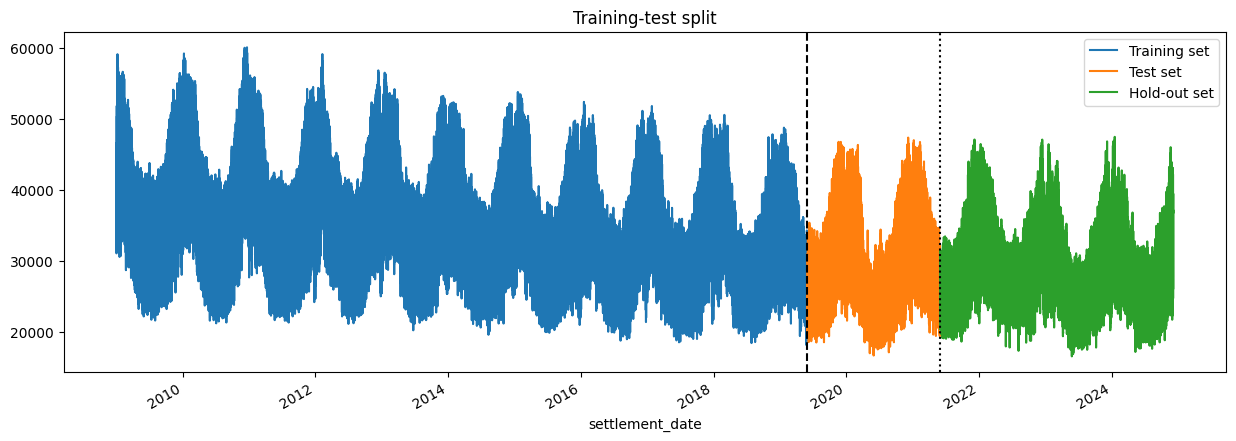

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend()

In [26]:
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

xgb_simple = xgb.XGBRegressor(
    n_estimators=500, 
    max_depth=3, 
    learning_rate=0.01, 
    early_stopping_rounds=50, 
    tree_method="hist",
    random_state=43, 
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
)

[0]	validation_0-rmse:7537.22500	validation_1-rmse:8346.85689
[100]	validation_0-rmse:4933.76548	validation_1-rmse:6453.99074
[200]	validation_0-rmse:3758.00700	validation_1-rmse:5413.53964
[300]	validation_0-rmse:3098.69455	validation_1-rmse:4775.37270
[400]	validation_0-rmse:2694.51449	validation_1-rmse:4381.90851
[499]	validation_0-rmse:2442.15493	validation_1-rmse:4133.70529


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


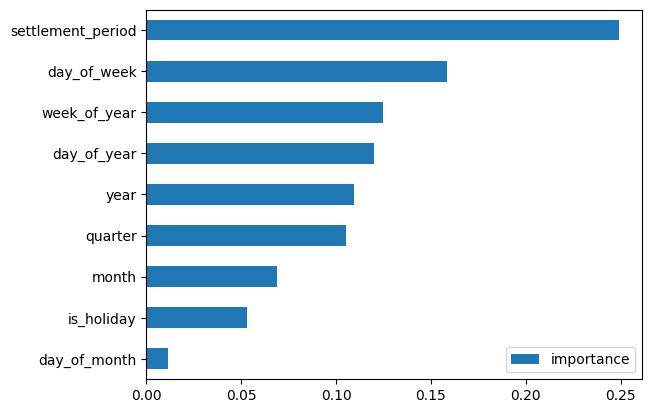

In [27]:
feat_imp_1 = pd.DataFrame(
    data=xgb_simple.feature_importances_,
    index=xgb_simple.get_booster().feature_names,
    columns=["importance"],
)

feat_imp_1.sort_values("importance", ascending=True, inplace=True)

feat_imp_1.plot(kind="barh");

In [28]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

In [33]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model is: 11.29
Root Mean Squared Error of the simple models is: 3786.88 MW


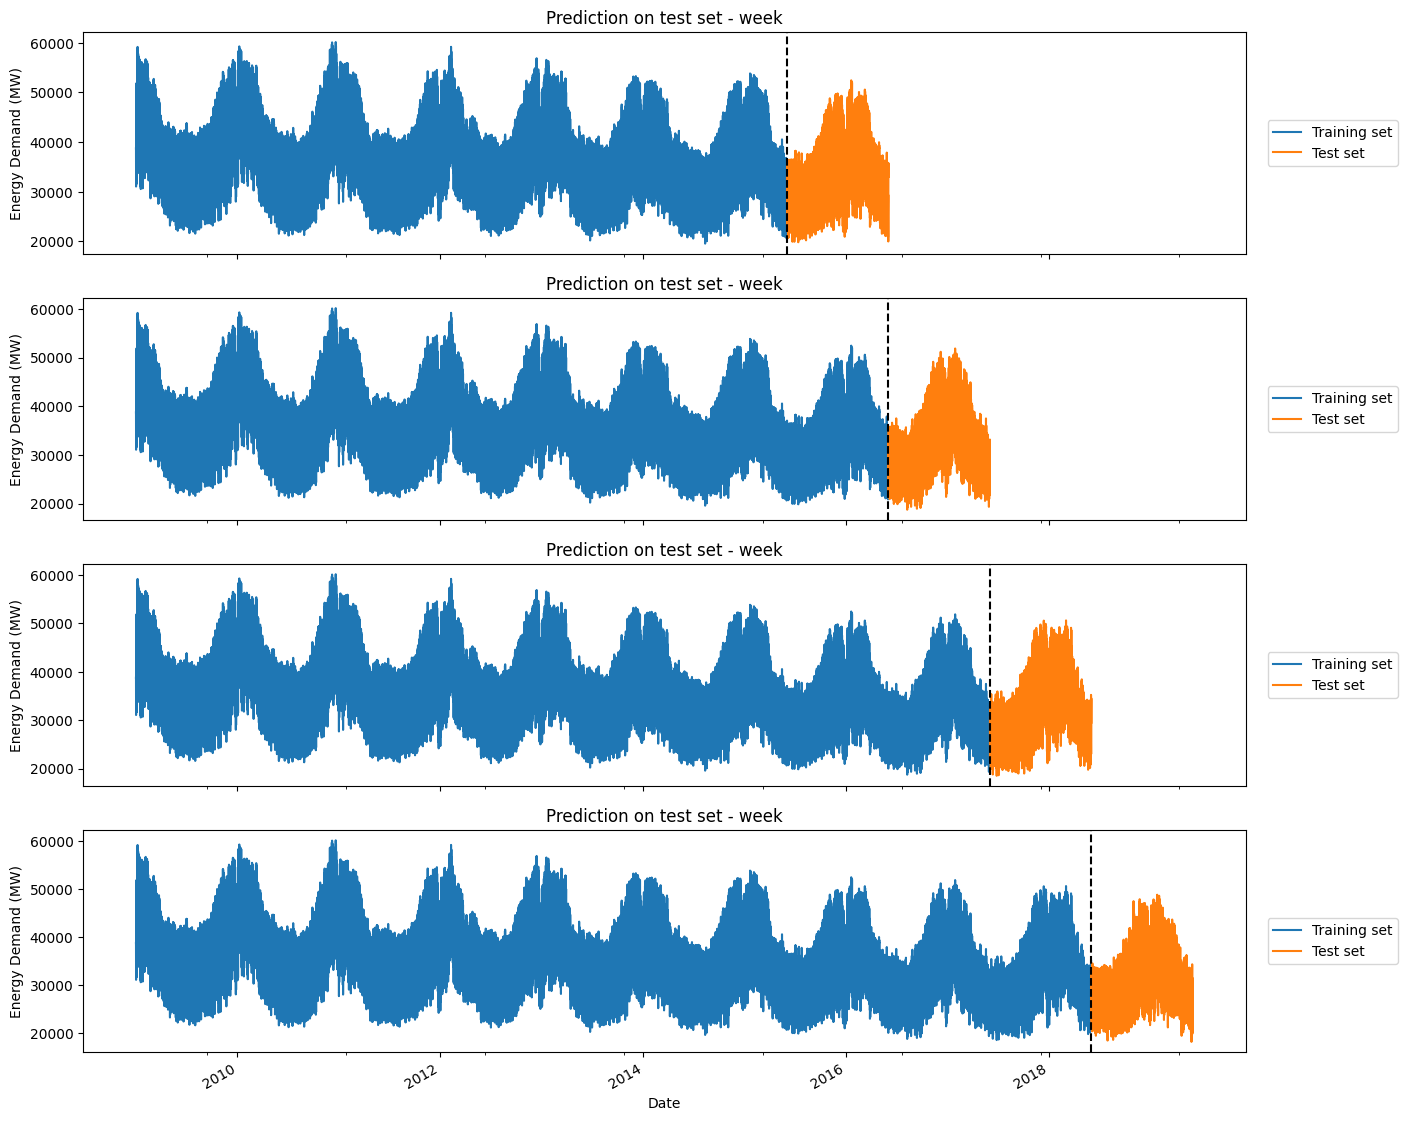

In [38]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best params from CV:
{'colsample_bytree': np.float64(0.5858138379589692), 'gamma': np.float64(1.8031783233965637), 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': np.float64(4.132892006727957), 'reg_lambda': np.float64(1.6635081424625908), 'subsample': np.float64(0.7733485933082965)}

Best CV score (neg RMSE): -2151.225439453125

Best params from CV:
{'colsample_bytree': np.float64(0.5858138379589692), 'gamma': np.float64(1.8031783233965637), 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': np.float64(4.132892006727957), 'reg_lambda': np.float64(1.6635081424625908), 'subsample': np.float64(0.7733485933082965)}

Best CV score (neg RMSE): -2151.225439453125
[0]	validation_0-rmse:8223.53000
[1]	validation_0-rmse:8073.87513
[0]	validation_0-rmse:8223.53000
[1]	validation_0-rmse:8073.87513
[2]	validation_0-rmse:7920.75378
[2]	validation_0-rmse:7920.75378
[3]	validation_0-rmse:7821.70856
[3]	validation_0-rmse:7821.70856
[4

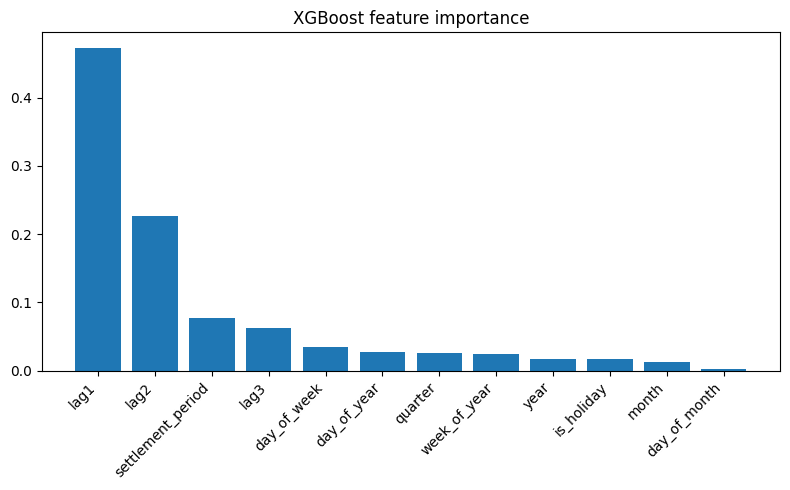

CPU times: total: 3min 20s
Wall time: 7min 58s


In [52]:
%%time

train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)
hold_out_data.index = pd.Index(hold_out_data.index)

FEATURES = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]

TARGET = "tsd"

X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

n_splits = 5
tss = TimeSeriesSplit(n_splits=n_splits)

base_estimator = xgb.XGBRegressor(
    booster="gbtree",
    tree_method="hist",
    random_state=43,
    objective="reg:squarederror",
    n_estimators=1500,
    learning_rate=0.02,
    early_stopping_rounds=80,
    n_jobs=-1,
    eval_metric="rmse",
)

from scipy.stats import randint, uniform

param_dist = {
    "max_depth": randint(3, 10),
    "min_child_weight": randint(1, 8),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "gamma": uniform(0, 3),
    "reg_alpha": uniform(0, 5),
    "reg_lambda": uniform(0, 5),
}

fit_params = {
    "eval_set": [(X_hold_out, y_hold_out)],
    "verbose": False,
}

xgb_search = RandomizedSearchCV(
    estimator=base_estimator,
    param_distributions=param_dist,
    n_iter=40,
    cv=tss,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=-1,
    random_state=43,
    error_score="raise",
)

xgb_search.fit(X_train, y_train, **fit_params)

print("\nBest params from CV:")
print(xgb_search.best_params_)
print("\nBest CV score (neg RMSE):", xgb_search.best_score_)

best_params = xgb_search.best_params_

final_model = xgb.XGBRegressor(
    **best_params,
    booster="gbtree",
    tree_method="hist",
    random_state=43,
    objective="reg:squarederror",
    n_estimators=1500,
    learning_rate=0.02,
    early_stopping_rounds=80,
    n_jobs=-1,
    eval_metric="rmse",
)

final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_hold_out, y_hold_out)],
    verbose=True,
)

y_pred_test = final_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("\nTest performance")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R^2 : {r2:.4f}")

In [54]:
train_data.to_csv("C:\Time_Series_XGB\data\processed/train_data.csv", index=False)
test_data.to_csv("C:\Time_Series_XGB\data\processed/test_data.csv", index=False)
hold_out_data.to_csv("C:\Time_Series_XGB\data\processed/hold_out_data.csv", index=False)

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
C:\Users\devip\AppData\Local\Temp\ipykernel_26388\1963700312.py:1: SyntaxWarning: invalid escape sequence '\T'
  train_data.to_csv("C:\Time_Series_XGB\data\processed/train_data.csv", index=False)
C:\Users\devip\AppData\Local\Temp\ipykernel_26388\1963700312.py:2: SyntaxWarning: invalid escape sequence '\T'
  test_data.to_csv("C:\Time_Series_XGB\data\processed/test_data.csv", index=False)
C:\Users\devip\AppData\Local\Temp\ipykernel_26388\1963700312.py:3: SyntaxWarning: invalid escape sequence '\T'
  hold_out_data.to_csv("C:\Time_Series_XGB\data\processed/hold_out_data.csv", index=False)


In [ ]:
import pickle
with open("C:\Time_Series_XGB\model/final_xgb_model.pkl", "wb") as f:
    pickle.dump(final_model, f) # type: ignore

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\devip\AppData\Local\Temp\ipykernel_26388\2445918663.py:2: SyntaxWarning: invalid escape sequence '\T'
  with open("C:\Time_Series_XGB\model/final_xgb_model.pkl", "wb") as f:
